## 2015104013 김형민 머신러닝개론 과제 1-3번 비지도 학습: 베이즈 가우시안 혼합 모델

기본적인 imports 및 plot과 save 선언

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from sklearn.datasets import make_blobs



가우시안 믹스처 모델의 그래프를 그리는 plot 함수를 선언

In [2]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

데이터 지정과 센트로이드 표시, 결정 경계를 표시해주는 함수 선언

In [3]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

### (1) make_blobs 레이블이 없는 데이터셋을 생성한다. (주교재의 그림9-2)

In [4]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [5]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

### (2) (1)의 데이터셋을 그림으로 그린다.

Saving figure blobs_plot


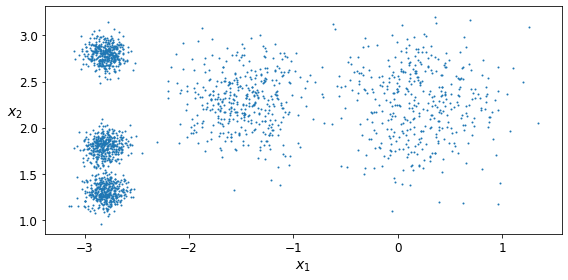

In [6]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

### (3) 베이즈 가우시안 혼합 모델을 사용하여 농도 가중치(weight_concentration_prior) 파라미터 값을 조정하면서 최적 클러스터 개수를 정한다.

In [7]:
from sklearn.mixture import BayesianGaussianMixture

In [8]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [9]:
np.round(bgm.weights_, 2)

array([0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ])

In [10]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.001, random_state=42)
bgm_normal = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=1, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)

bgm_low.fit(X)
bgm_normal.fit(X)
bgm_high.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=10000,
                        weight_concentration_prior_type='dirichlet_process')

In [11]:
np.round(bgm_low.weights_, 2)

array([0. , 0.2, 0.2, 0.2, 0. , 0.2, 0.2, 0. , 0. , 0. ])

5개의 클러스터가 최적

In [12]:
np.round(bgm_normal.weights_, 2)

array([0. , 0.2, 0.2, 0.2, 0. , 0.2, 0.2, 0. , 0. , 0. ])

5개의 클러스터가 최적

In [13]:
np.round(bgm_high.weights_, 2)

array([0.  , 0.2 , 0.07, 0.2 , 0.  , 0.2 , 0.2 , 0.  , 0.  , 0.12])

5개의 클러스터가 최적

### (4) 센트로이드와 결정 경계를 포함한 클러스터링 결과를 그림으로 그려 비교한다.

C:\Users\dorit\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  del sys.path[0]
C:\Users\dorit\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Log scale: values of z <= 0 have been masked
C:\Users\dorit\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  del sys.path[0]
C:\Users\dorit\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Log scale: values of z <= 0 have been masked


Saving figure mixture_concentration_prior_plot


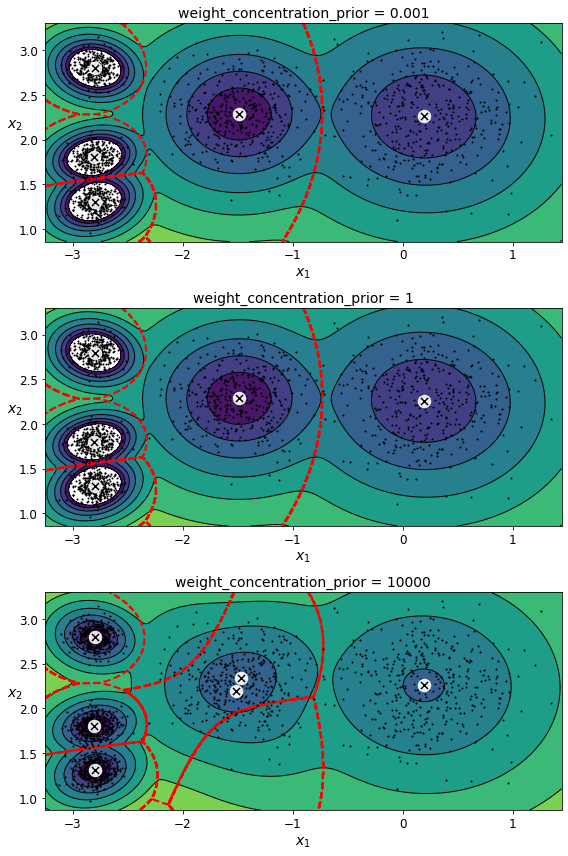

In [14]:
plt.figure(figsize=(8, 12))

plt.subplot(311)
plot_gaussian_mixture(bgm_low, X)
plt.title("weight_concentration_prior = 0.001", fontsize=14)

plt.subplot(312)
plot_gaussian_mixture(bgm_normal, X)
plt.title("weight_concentration_prior = 1", fontsize=14)

plt.subplot(313)
plot_gaussian_mixture(bgm_high, X)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()